In [33]:
import numpy as np 
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, to_tree
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap


In [21]:
from module.data_prep import prep_grn_data, prep_go_meta, prep_foodweb_data, prep_recipe_data
from module.utils import get_entropy

from fvec.fvec import bipartite_cooarray, adjacency_cooarray, csr_row_norm, csr_col_norm

In [22]:
cwd = Path.cwd()


In [24]:
save_things=False

# Recipe network:

In [25]:
# rn_datadir = '../../data/rn'
# rn_processed_dir = rn_datadir + '/processed'

rn_processed_dir = cwd.parent.parent / 'data' / 'rn' / 'processed'

if save_things:
    rn_fig_dir = cwd.parent / 'figures' / 'rn'
    rn_fig_dir.mkdir(parents=True, exist_ok=True)

In [26]:
rn_df, meta_df = prep_recipe_data()

cuisine_list = meta_df.cuisine.dropna().unique()

recipe_list = rn_df.r_id.dropna().unique()

ingredient_list = list(set(rn_df.ingredient.dropna().unique()) - {''})
# rn_df = rn_df[rn_df['ingredient'].isin(ingredient_list)].reset_index(drop=True)
rn_df = rn_df[rn_df['ingredient'].isin(ingredient_list)].reset_index(drop=True)

In [27]:
# norm_is_c_vec_df = pd.read_parquet(f'{rn_processed_dir}/is_c_vectors.parquet')
# cnorm_cs_i_bpt_df = pd.read_parquet(f'{rn_processed_dir}/cs_i_vectors.parquet')

In [28]:
a_RC_coo, recipe_row, cuisine_col = bipartite_cooarray( \
    df=meta_df.sort_values(['r_id', 'cuisine']), \
    row_col=['r_id', 'cuisine'], \
    weight=False, \
    row_order=list(recipe_list), \
    col_order=list(cuisine_list))

In [29]:
a_RI_coo, recipe_row, ingredient_col = bipartite_cooarray( \
    df=rn_df.sort_values(['r_id', 'ingredient']), \
    row_col=['r_id', 'ingredient'], \
    weight=False, 
    row_order=list(recipe_list), \
    col_order=list(ingredient_list))

In [30]:
a_CI_csr = (a_RC_coo.T @ a_RI_coo).tocsr() # csr array

# normalisation:
a_CI_csr_normalised = csr_row_norm(a_CI_csr)

norm_is_c_vec_df = pd.DataFrame(a_CI_csr_normalised.toarray(), columns=ingredient_col, index=cuisine_col)

In [34]:
white_red = LinearSegmentedColormap.from_list("white_red", ["white", "red"])

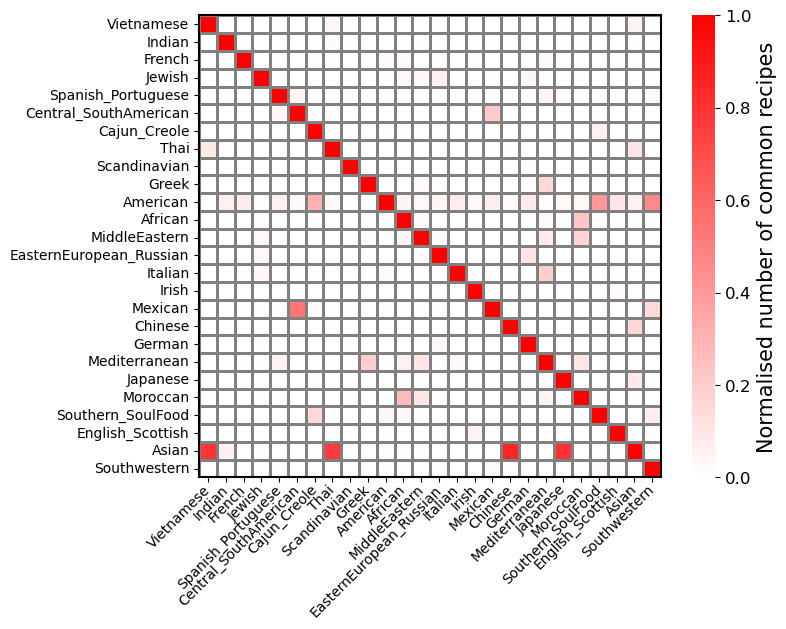

In [35]:
# normalised 
cc_array = (a_RC_coo.T @ a_RC_coo).toarray()

normed_cc_array = cc_array/np.diag(cc_array)

# mask = np.triu(np.ones_like(cc_array, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 6))

# sns.heatmap(data, annot=True, fmt=".2f", cmap="viridis", ax=ax)

# Force square cells
hm = sns.heatmap(normed_cc_array,
        cmap=white_red, ax=ax, linewidths=1, linecolor='grey',
)
colorbar = hm.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12)
# colorbar.ax.set(labelsize=12)
colorbar.set_label('Normalised number of common recipes', size=15)

# Customize tick label rotation and axis labels
ax.set_xticks(np.arange(len(cuisine_col))+0.5)
ax.set_xticklabels(cuisine_col, rotation=45, ha='right', va='center',rotation_mode="anchor")
ax.set_aspect('equal')

ax.set_yticks(np.arange(len(cuisine_col))+0.5)
ax.set_yticklabels(cuisine_col, rotation=0)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.5)

# save_things=True
if save_things:
    plt.savefig(rn_fig_dir / 'fw_common_recipes.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(rn_fig_dir / 'fw_common_recipes.png', dpi=300, bbox_inches='tight', transparent=True)
    

plt.show()


## entropic analysis:

In [37]:
least_n = int(min(a_RC_coo.toarray().sum(axis=0)))

In [38]:
div_sampled = []


N = 100 # number of samples

a_RI = a_RI_coo.toarray()
a_RC = a_RC_coo.toarray()

for i in range(len(cuisine_col)):
    
    nth_c_i_vec = a_RI[np.arange(len(recipe_row))[a_RC[:, i].astype(bool)]] # binary vector of ingredients for each recipe in nth cuisine
    n_recipes = nth_c_i_vec.shape[0]

    nth_div_of_avgs = []
    nth_avg_divs = []
    nth_ent_of_avgs = []
    nth_avg_ents = []
    

    for j in range(N):
        rng = np.random.default_rng(seed=j)

        sample_inds = rng.choice(a=np.arange(n_recipes), size=least_n, replace=False)
        sample_nth_c_i_vec = nth_c_i_vec[sample_inds]

        sample_nth_c_i_pvec = sample_nth_c_i_vec/sample_nth_c_i_vec.sum(axis=1)[:,None] # normalised average vector of ingredients in nth cuisine.
        sample_nth_avg_div = np.mean(sample_nth_c_i_vec.sum(axis=1)) # average number of ingredients per recipe in the nth cuisine

        sample_nth_avg_ent = np.mean(np.log(sample_nth_c_i_vec.sum(axis=1))) # entropy of of each recipe. Assumes one ingredient use per recipe, so is a maximum entropy distribution.
        sample_nth_avg_cs_i_vec = sample_nth_c_i_pvec.mean(axis=0) # average vector of ingredients in the nth cuisine
        v = sample_nth_avg_cs_i_vec[sample_nth_avg_cs_i_vec > 0] 
        ent_of_avg = -sum(v * np.log(v)) # entropy of the average vector of ingredients 
        div_of_avg = np.exp(ent_of_avg)
        nth_div_of_avgs.append(div_of_avg)
        nth_avg_divs.append(sample_nth_avg_div)
        nth_ent_of_avgs.append(ent_of_avg)
        nth_avg_ents.append(sample_nth_avg_ent)

    mean_div_avg = np.mean(nth_div_of_avgs)
    sem_div_avg = np.std(nth_div_of_avgs)/np.sqrt(least_n)

    mean_avg_div = np.mean(nth_avg_divs)
    sem_avg_div = np.std(nth_avg_divs)/np.sqrt(least_n)

    mean_ent_avg = np.mean(nth_ent_of_avgs)
    sem_ent_avg = np.std(nth_ent_of_avgs)/np.sqrt(least_n)

    mean_avg_ent = np.mean(nth_avg_ents)
    sem_avg_ent = np.std(nth_avg_ents)/np.sqrt(least_n)


    div_sampled.append({'cuisine':cuisine_col[i], 'mean_div_avg': mean_div_avg,\
                        'sem_div_avg':sem_div_avg, 'mean_avg_div':mean_avg_div, \
                        'sem_avg_div':sem_avg_div, 'mean_ent_avg': mean_ent_avg,\
                        'sem_ent_avg':sem_ent_avg, 'mean_avg_ent':mean_avg_ent, \
                        'sem_avg_ent':sem_avg_ent,})


c_sampled_delta_s_df = pd.DataFrame(div_sampled)

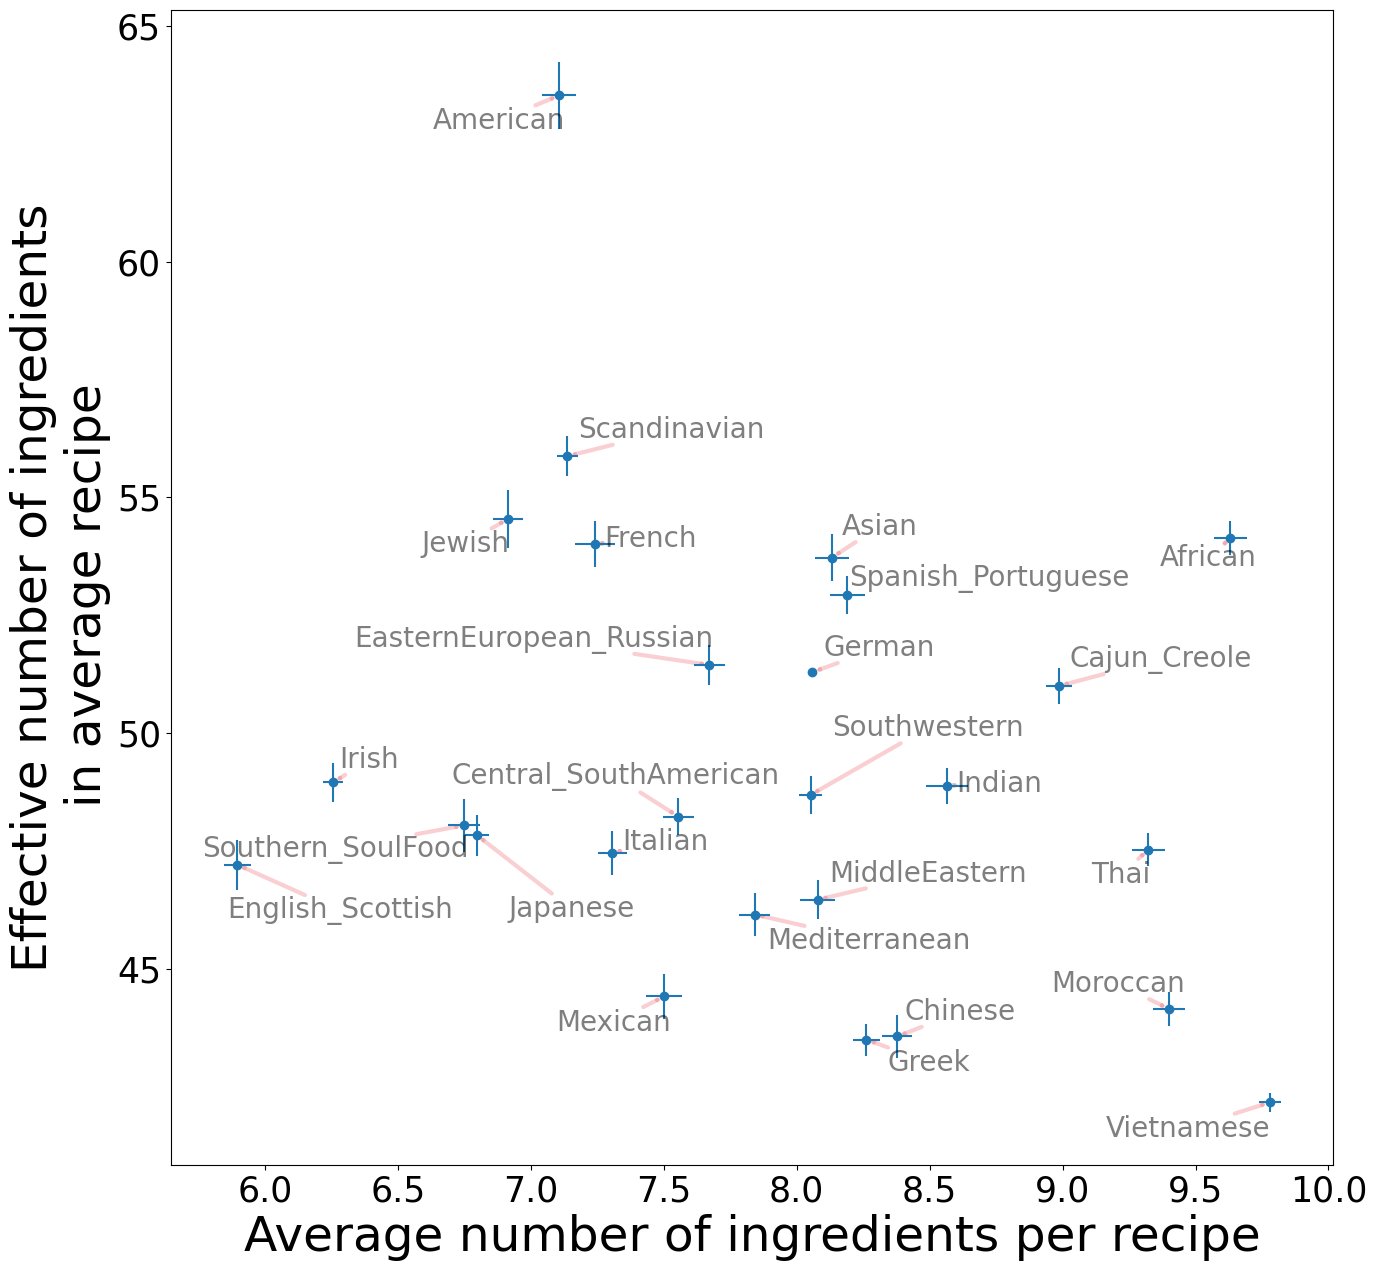

In [39]:
plt.figure(figsize=(15,15))

plt.errorbar(y=c_sampled_delta_s_df['mean_div_avg'].values, x=c_sampled_delta_s_df['mean_avg_div'].values, fmt='o',
             yerr = c_sampled_delta_s_df['sem_div_avg'].values, xerr = c_sampled_delta_s_df['sem_avg_div'].values)


text_prep = c_sampled_delta_s_df.reset_index()[['cuisine', 'mean_avg_div', 'mean_div_avg']].to_numpy()
texts = [plt.text(i[1], i[2], f'{i[0]}', ha='center', va='center', alpha=0.5, fontsize=20) for i in text_prep]
adjust_text(texts,expand=(1.2, 1.8), arrowprops=dict(linewidth=3, arrowstyle='->', color='#e2102233'))


plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True

plt.xticks(size=25, )
plt.yticks(size=25, )
plt.ylabel('Effective number of ingredients\nin average recipe ', size=35, )
plt.xlabel(r"Average number of ingredients per recipe", size=35,)

if save_things:
    plt.savefig(rn_fig_dir / 'rn_div_dist_sampled.pdf', dpi=300,  bbox_inches='tight', transparent=True)
    plt.savefig(rn_fig_dir / 'rn_div_dist_sampled.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

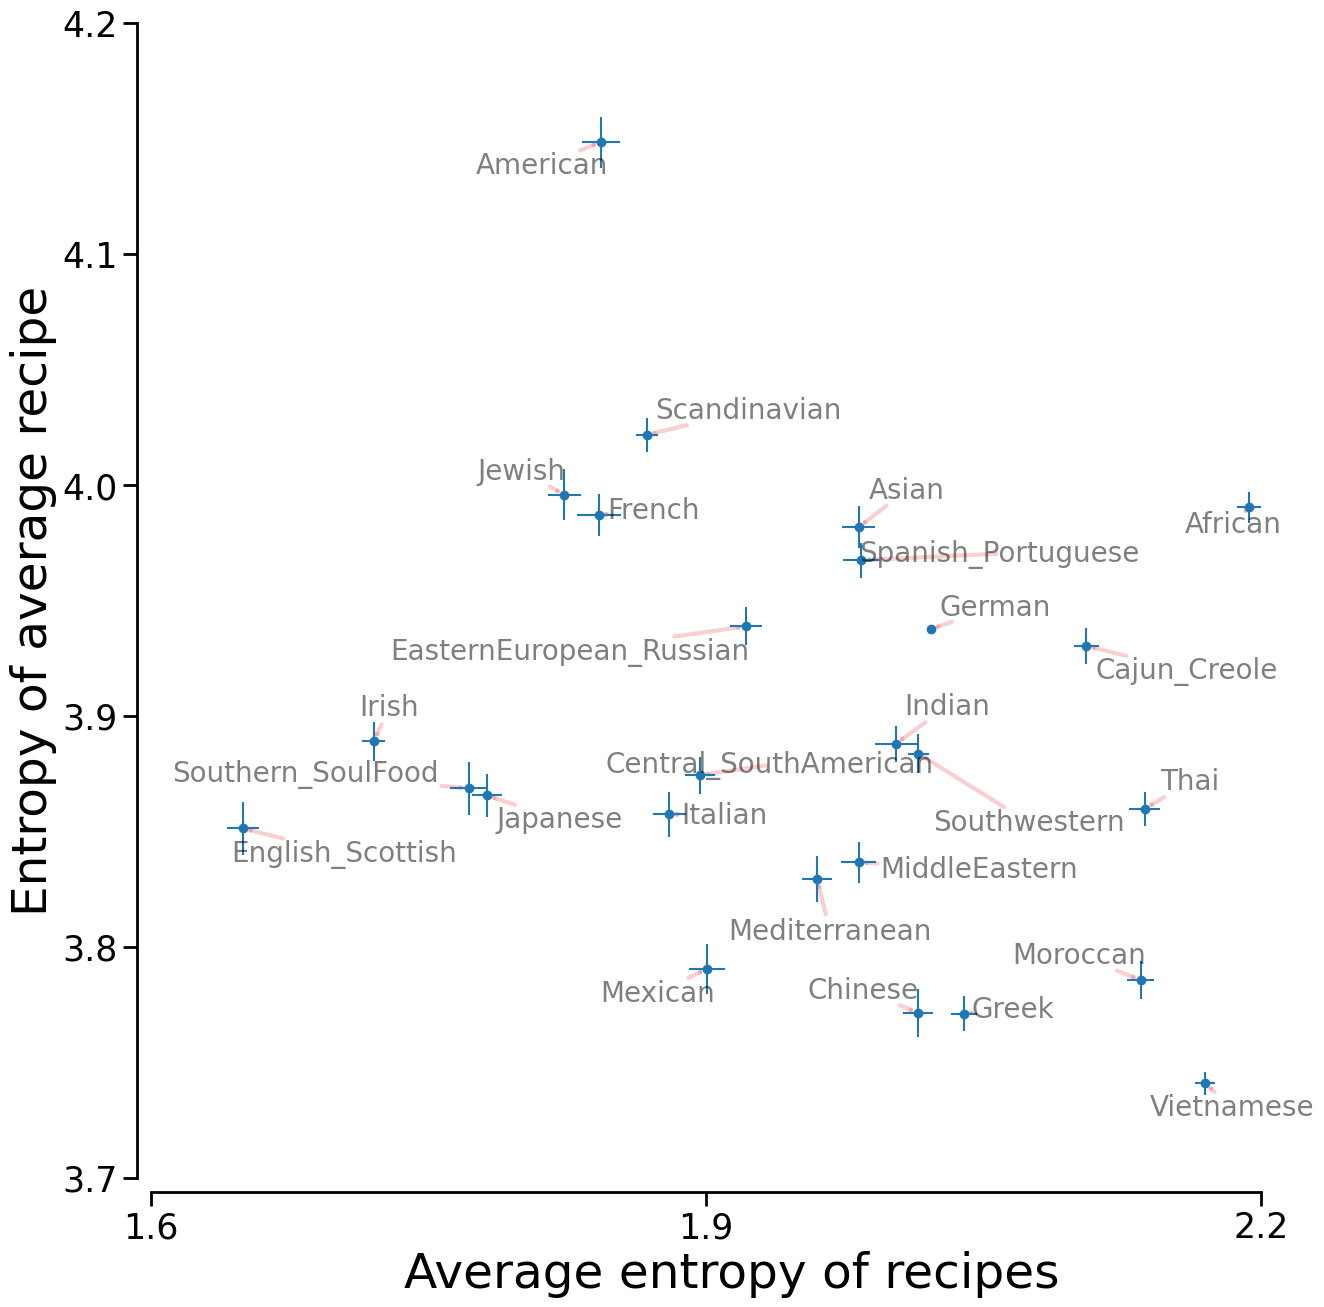

In [40]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.errorbar(y=c_sampled_delta_s_df['mean_ent_avg'].values, 
            x=c_sampled_delta_s_df['mean_avg_ent'].values, 
            fmt='o',
            yerr=c_sampled_delta_s_df['sem_ent_avg'].values, 
            xerr=c_sampled_delta_s_df['sem_avg_ent'].values)

text_prep = c_sampled_delta_s_df.reset_index()[['cuisine', 'mean_avg_ent', 'mean_ent_avg']].to_numpy()
texts = [ax.text(i[1], i[2], f'{i[0]}', ha='center', va='center', alpha=0.5, fontsize=20) for i in text_prep]
adjust_text(texts, expand=(1.2, 1.8), arrowprops=dict(linewidth=3, arrowstyle='->', color='#e2102233'))

ax.tick_params(axis='both', labelsize=30)
ax.set_ylabel('Entropy of average recipe', size=35)
ax.set_xlabel("Average entropy of recipes", size=35)
ax.tick_params(width=2, size=10, labelsize=15)
ax.set_yticks(np.arange(3.7, 4.3, 0.1))
ax.set_xticks([1.6, 1.9, 2.2])
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
for pos in ['bottom','left',]:
    ax.spines[pos].set_linewidth(2)

sns.despine(ax=ax, offset=10, trim=True)

if save_things:
    plt.savefig(rn_fig_dir / 'rn_ent_dist_sampled.pdf', dpi=300,  bbox_inches='tight', transparent=True)
    plt.savefig(rn_fig_dir / 'rn_ent_dist_sampled.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
# 

# Food web:

In [41]:
fw_processed_dir = cwd.parent.parent / 'data' / 'fw' / 'processed'
if save_things:
    fw_fig_dir = cwd.parent / 'figures' / 'fw'
    fw_fig_dir.mkdir(parents=True, exist_ok=True)


In [42]:
fw_df, meta_df_filtered, meta_fine_df_filtered, meta_fine_df_2_filtered = prep_foodweb_data()

In [43]:
fw_data = {'fw': fw_df, 'meta_f': meta_df_filtered, 'meta_ff': meta_fine_df_filtered, 'meta_fff': meta_fine_df_2_filtered}

vectors = {}
for key in ['f', 'ff', 'fff']: # coarseness of food web animal labelling: more 'f's the finer...
    v = pd.read_parquet( fw_processed_dir / f'{key}_vectors.parquet')
    vectors[f'{key}_vectors'] = v

In [44]:
mode = 'fff' # which level of coarseness in the food web animal labelling to use
fw_meta = fw_data[f'meta_{mode}']
fw_vectors = vectors[f'{mode}_vectors']

unique_types = fw_meta['type'].unique()
in_cols = [i + '_in' for i in unique_types]
out_cols = [i + '_out' for i in unique_types]

In [45]:
preys = set(fw_df.prey)
predators = set(fw_df.predator)

all_animals = sorted(list(preys | predators))

In [48]:
bpt_AS_coo, animal_row, type_col = bipartite_cooarray(df=fw_meta.sort_values(['node', 'type']), row_col=['node', 'type'], weight=False, row_order=all_animals)
a_AA_coo, _ = adjacency_cooarray(df=fw_df, row_col=['prey', 'predator'], id_order=all_animals, weight=False, directed=True)

a_AS_out = (a_AA_coo @ bpt_AS_coo).tocsr().astype(int) # out matrix
a_AS_in = (a_AA_coo.T @ bpt_AS_coo).tocsr().astype(int) # in matrix

# out matrix normalisation:
a_AS_out_normalised = csr_row_norm(a_AS_out)

# in matrix normalisation:
a_AS_in_normalised = csr_row_norm(a_AS_in)

# put together into one dataframe:
all_col_names = np.concatenate([
    np.char.add(type_col, '_out'),
    np.char.add(type_col, '_in')
])
all_norm_vec_df = pd.DataFrame(sp.sparse.hstack([a_AS_out_normalised, a_AS_in_normalised]).toarray(), columns=all_col_names, index=animal_row)


In [49]:
for io, cols in zip(['in', 'out'], [in_cols, out_cols]):
    fw_vectors[io + '_entropy'] = fw_vectors.loc[:, cols].apply(get_entropy, axis=1)

In [50]:
ent_cols = [io + '_entropy' for io in ['in', 'out']]

In [51]:
ent_df = fw_vectors.loc[all_animals, ent_cols]
e_AE_arr = ent_df.to_numpy()

In [52]:
a_AA_out = a_AA_coo.toarray().astype(int)
a_AA_in = a_AA_coo.T.toarray().astype(int)

a_AS_out_norm_arr = a_AS_out_normalised.toarray()
a_AS_in_norm_arr = a_AS_in_normalised.toarray()

In [53]:
ud_io_ent = {}
for i in range(len(all_animals)):
    nth_ent_dict = {}
    for ud, io_arr in zip(['ds', 'us'], [a_AA_out, a_AA_in]):

        ud_inds = np.arange(len(all_animals))[io_arr[i,:].astype(bool)] # inds of organisms that are downstream
        if len(ud_inds) == 0:
            nth_ent_dict[f'out_ent_of_avg_{ud}'] = np.nan
            nth_ent_dict[f'in_ent_of_avg_{ud}'] = np.nan
            nth_ent_dict[f'in_entropy_{ud}'] = np.nan
            nth_ent_dict[f'out_entropy_{ud}'] = np.nan
            continue


        out_vec = a_AS_out_norm_arr[ud_inds]
        in_vec = a_AS_in_norm_arr[ud_inds]

        # make sure no empty rows dilue the mean:
        out_inds = np.arange(out_vec.shape[0])[abs(out_vec.sum(axis=1)-1.)<1e-8]
        # out_vec = out_vec[out_inds]

        in_inds = np.arange(in_vec.shape[0])[abs(in_vec.sum(axis=1)-1.)<1e-8]
        io_ent = e_AE_arr[ud_inds] 
        

        
        if len(out_inds)==0:
            out_ent_of_avg = np.nan
            avg_out_ent = np.nan
        elif len(out_inds)>0:
            out_vec = out_vec[out_inds]
            out_ent_of_avg = get_entropy(out_vec.mean(axis=0), delta=0.)
            avg_out_ent = io_ent[out_inds, 1].mean(axis=0) # average out entropy
            if abs(out_vec.mean(axis=0).sum()-1.)>1e-8:
                print(out_vec.mean(axis=0))
                print(i, ud)

        if len(in_inds)==0:
            in_ent_of_avg = np.nan
            avg_in_ent = np.nan
        elif len(in_inds)>0:
            in_vec = in_vec[in_inds]
            in_ent_of_avg = get_entropy(in_vec.mean(axis=0), delta=0.)
            avg_in_ent = io_ent[in_inds, 0].mean(axis=0) # average in entropy
                # break
        # if len(ud_inds) == 0:
        #     nth_ent_dict[f'out_ent_of_avg_{ud}'] = np.nan
        #     nth_ent_dict[f'in_ent_of_avg_{ud}'] = np.nan
        #     nth_ent_dict[f'in_entropy_{ud}'] = np.nan
        #     nth_ent_dict[f'out_entropy_{ud}'] = np.nan
        #     continue


        nth_ent_dict[f'out_ent_of_avg_{ud}'] = out_ent_of_avg
        nth_ent_dict[f'in_ent_of_avg_{ud}'] = in_ent_of_avg

        # nth_ent_dict[f'avg_in_ent_{ud}'] = avg_io_ent[0]
        # nth_ent_dict[f'avg_out_ent_{ud}'] = avg_io_ent[1]
        nth_ent_dict[f'in_entropy_{ud}'] = avg_in_ent
        nth_ent_dict[f'out_entropy_{ud}'] = avg_out_ent
    ud_io_ent[all_animals[i]] = nth_ent_dict
    # else:
    #     continue
    # break  # outer break if inner was broken



In [54]:
ud_inds = np.arange(len(all_animals))[a_AA_out[92,:].astype(bool)]

In [55]:
in_vec = a_AS_in_norm_arr[ud_inds]
out_vec = a_AS_out_norm_arr[ud_inds]


In [56]:
in_inds = np.arange(in_vec.shape[0])[abs(in_vec.sum(axis=1)-1.)<1e-8]
# in_vec = in_vec[in_inds]
in_inds

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [57]:
get_entropy(in_vec[in_inds, :].mean(axis=0))

2.3365730913738334

In [58]:
mean_in_vec = in_vec[in_inds, :].mean(axis=0)

In [59]:
get_entropy(mean_in_vec[mean_in_vec>1e-16], delta=0.)

2.3365730913738334

In [60]:
get_entropy(mean_in_vec[mean_in_vec>1e-3], delta=0.)

2.3239041467275565

In [61]:
io_ent = e_AE_arr[ud_inds] 

io_ent

array([[ 1.87752428,  0.82395922],
       [ 1.35168119,  1.78098656],
       [ 1.69804459,  0.69314718],
       [ 1.27985423,  1.9616663 ],
       [ 2.14484756, -0.        ],
       [ 1.28529302,  1.58109375],
       [ 1.05492017,  1.79873596],
       [ 1.96753047,  1.73286795],
       [ 1.03603348, -0.        ],
       [ 1.80364999,         nan],
       [ 1.32126419,         nan],
       [ 1.45831922,  1.60205592],
       [ 1.75192641,  1.70947278],
       [ 2.21785457,  2.00755631],
       [ 2.12205775,  1.93642273],
       [ 0.87113327,  0.69314718],
       [ 1.59139426,         nan],
       [ 1.40083175,         nan],
       [ 1.79641068, -0.        ],
       [ 2.26885766,  1.63263093],
       [ 1.6114722 ,  1.67819768],
       [ 1.79641068, -0.        ],
       [ 1.82916037,         nan],
       [ 1.89451418, -0.        ],
       [ 1.73869927, -0.        ],
       [ 1.30059201,  1.09861229],
       [ 0.94304567,         nan],
       [ 1.51360268,  1.31078368],
       [ 1.99574331,

In [62]:
avg_out_ent = io_ent[out_inds, 1].mean(axis=0)
avg_out_ent

1.3149398135225088

In [63]:
all_ud_entropies = pd.DataFrame.from_dict(ud_io_ent, orient='index')

In [64]:
for io in ['in', 'out']:
    for ud in ['us', 'ds']:
        all_ud_entropies[f'{io}_diff_{ud}'] = all_ud_entropies[f'{io}_ent_of_avg_{ud}'] - all_ud_entropies[f'{io}_entropy_{ud}']

0 [ 0.06080888 -0.81504131]
35 [-0.11549823  0.65155592]
45 [ 0.95925936 -0.58593946]


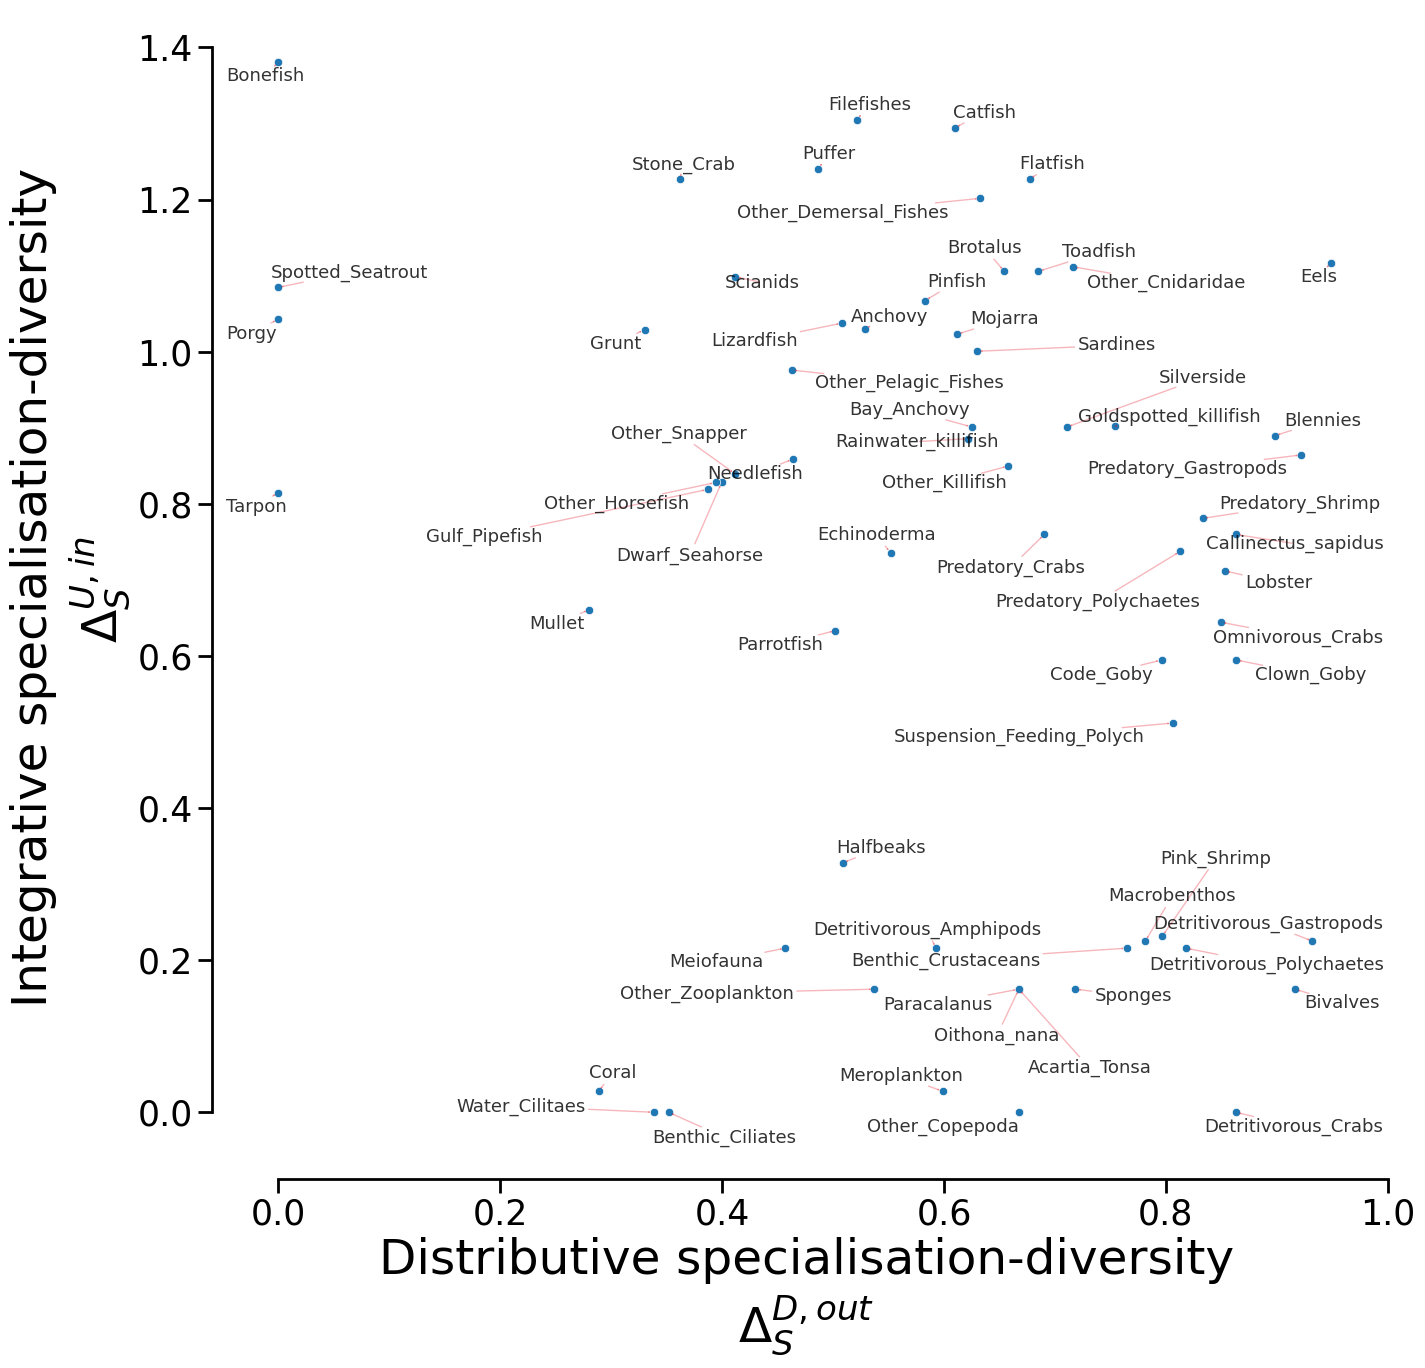

In [65]:
# cents = ['closeness_in', 'closeness_out','betweenness', 'eigenvector_out', 'eigenvector_in' ]

# for cent in cents:
fig, ax = plt.subplots(figsize=(15, 15))
x = "out_diff_ds"
y = "in_diff_us"



hm = sns.scatterplot(all_ud_entropies[[x,y]].dropna(), x=x, y=y, alpha=1, ax=ax)

# sns.scatterplot(hubs_df, x=x, y=y)


# text_prep = hubs_df[['id', x,y]].dropna().to_numpy()
# texts = [plt.text(i[1], i[2], f'{i[0]}', ha='center', va='center', alpha=0.8, fontsize=15) for i in text_prep]
# adjust_text(texts,expand=(1.4, 1.5), arrowprops=dict(arrowstyle='->', color='#e210224d'))

text_prep = all_ud_entropies[[x,y]].dropna().reset_index()[['index', x, y]].to_numpy()
other_text = [plt.text(i[1], i[2], f'{i[0]}', ha='center', va='center', alpha=0.8, fontsize=13) for i in text_prep]
adjust_text(other_text,expand=(1.5, 1.6), arrowprops=dict(arrowstyle='->', color='#e210224d'))

ax.tick_params(axis='both', labelsize=30)
ax.set_ylabel("Integrative specialisation-diversity\n$\Delta_S^{U, in}$ ", size=35)
ax.set_xlabel("Distributive specialisation-diversity\n$\Delta_S^{D, out}$ ",  size=35)
ax.tick_params(width=2, size=10, labelsize=15)
# ax.set_yticks(np.arange(3.7, 4.3, 0.1))
ax.set_xticks(np.arange(0., 1.2, 0.2))
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
for pos in ['bottom','left',]:
    ax.spines[pos].set_linewidth(2)

sns.despine(ax=ax, offset=10, trim=True)
# save_things=False
# if save_things: 
#     plt.savefig(f'../figures/fw/fw_ent_dist.png')
#     plt.savefig(f'../figures/fw/fw_ent_dist.pdf')
save_things=False
if save_things:
    plt.savefig(fw_fig_dir / 'fw_ent_dist.pdf', dpi=300,  bbox_inches='tight', transparent=True)
    plt.savefig(fw_fig_dir / 'fw_ent_dist.png', dpi=300, bbox_inches='tight', transparent=True)


plt.show()

 

In [66]:
# old_ents = pd.read_parquet('../../data/fw/old/fw_ff_ud_ents.parquet')

In [67]:
# old_ents.sort_index(axis=1)

In [68]:
# all_ud_entropies.sort_index(axis=1)

In [69]:
# (all_ud_entropies.fillna(0)-old_ents.fillna(0)).sum(axis=0).sort_values().head(50)

In [70]:
# (all_ud_entropies.fillna(0)-old_ents.fillna(0))[(all_ud_entropies.fillna(0)-old_ents.fillna(0)) > 1e-20].dropna(how='all')

In [71]:
# (all_ud_entropies.fillna(0)-old_ents.fillna(0))[(all_ud_entropies.fillna(0)-old_ents.fillna(0)) > 1e-20].dropna(how='all').sum(axis=1)

In [72]:
# (all_ud_entropies.fillna(0)-old_ents.fillna(0)).sum(axis=1).sort_values()

In [73]:
# all_ud_entropies.reset_index().query('index=="Predatory_Shrimp"')

In [74]:
# (all_ud_entropies.fillna(0)-old_ents.fillna(0)).loc['Predatory_Shrimp']

In [75]:
# (old_ents.fillna(0)).loc['Predatory_Shrimp'].sort_index()

In [76]:
# (all_ud_entropies.fillna(0)).loc['Predatory_Shrimp'].sort_index()

In [77]:
# (all_ud_entropies.fillna(0)-old_ents.fillna(0)).sum(axis=0)